# Retrieving The Data

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np

In [36]:
df = pd.read_csv("train.csv")
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\r\nWhy the edits made under my use...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\r\nMore\r\nI can't make any real suggestions...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# Preprocess

In [3]:
from tensorflow.keras.layers import TextVectorization

X = df['comment_text']
y = df[df.columns[2:]].values

MAX_FEATURES = 200000 # number of words in the vocab
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [4]:
vectorizer.adapt(X.values)

In [5]:
vectorized_text = vectorizer(X.values)

In [6]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [7]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

# Create Sequential Model

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding
model = Sequential()
# Create the embedding layer
model.add(Embedding(MAX_FEATURES, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer
model.add(Dense(6, activation='sigmoid'))

In [35]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 1800, 32)       │     6,400,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 64)             │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,474,964 (74.29 MB)

 Trainable params: 6,491,654 (24.76 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 12,983,310 (49.53 MB)

In [13]:
history = model.fit(train, epochs=5, validation_data=val)

Epoch 1/5
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 4711s 675ms/step - loss: 0.0443 - val_loss: 0.0391
Epoch 2/5
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 2518s 355ms/step - loss: 0.0393 - val_loss: 0.0343
Epoch 3/5
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 2811s 403ms/step - loss: 0.0352 - val_loss: 0.0305
Epoch 4/5
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 2814s 403ms/step - loss: 0.0309 - val_loss: 0.0275
Epoch 5/5
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 1682s 241ms/step - loss: 0.0274 - val_loss: 0.0240


<Figure size 800x500 with 0 Axes>

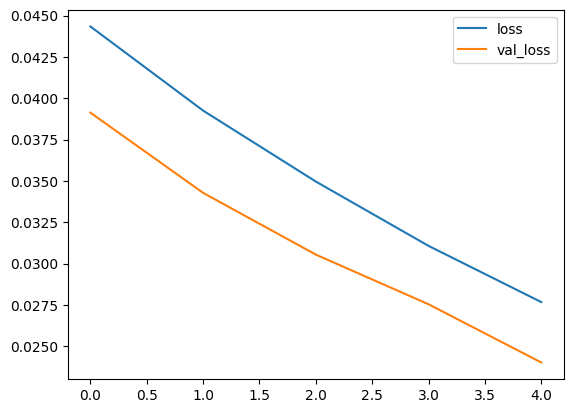

In [14]:
from matplotlib import pyplot as plt
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

# Make Predictions

In [15]:
input_text = vectorizer('You freaking suck! I am going to hit you.')
res = model.predict(np.array([input_text]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


In [16]:
(res > 0.5).astype(int)

array([[1, 0, 1, 0, 1, 0]])

In [17]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [18]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

# Evaluate Model

In [19]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [20]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━

In [21]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.9047021865844727, Recall:0.8490732312202454, Accuracy:0.526579737663269


# Testing

In [22]:
import tensorflow as tf

In [23]:
model.save('toxicity.h5.keras')

In [24]:
model = tf.keras.models.load_model('toxicity.h5.keras')

In [25]:
input_str = vectorizer('hey i freaken hate you!')

In [26]:
res = model.predict(np.array([input_str]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


In [27]:
res

array([[0.94615847, 0.00580381, 0.0964723 , 0.01184139, 0.598838  ,
        0.06807121]], dtype=float32)

In [44]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    output = {}
    for idx, col in enumerate(df.columns[2:]): 
        output[col] = results[0][idx] > 0.5  
    
    return output

In [49]:
# Test with an example comment
comment = "you are so ugly"
result = score_comment(comment)

print("Toxicity Analysis Result:")
for label, value in result.items():
    print(f"{label}: {'Toxic' if value else 'Not Toxic'}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Toxicity Analysis Result:
toxic: Toxic
severe_toxic: Not Toxic
obscene: Not Toxic
threat: Not Toxic
insult: Toxic
identity_hate: Not Toxic
